This is based on Gil's work: 
https://signal.onepointltd.com/post/102gc83/sentiment-analysis-with-yelp-and-bert
https://github.com/onepointconsulting/yelp_bert/blob/master/preprocess_data.ipynb

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))
from pathlib import Path
import json
import seaborn as sns
from collections import Counter

/kaggle/input/yelp-dataset/yelp_academic_dataset_review.json
/kaggle/input/yelp-dataset/yelp_academic_dataset_checkin.json
/kaggle/input/yelp-dataset/yelp_academic_dataset_business.json
/kaggle/input/yelp-dataset/yelp_academic_dataset_tip.json
/kaggle/input/yelp-dataset/yelp_academic_dataset_user.json
/kaggle/input/yelp-dataset/Dataset_Agreement.pdf


In [2]:
review_file = '/kaggle/input/yelp-dataset/yelp_academic_dataset_review.json'

In [3]:
sample_size = 2000000
simplified_reviews = './yelp_reviews_simple_{sample_size}.json'

def extract_simplified(source, target, lines=1000):
    with open(target, 'w') as sr:
        cnt = 0;
        with open(source) as file:
            line = file.readline()
            while line:
                cnt += 1
                if cnt == lines:
                    break
                if cnt % 100_000 == 0:
                    print(f'Processed {cnt}')
                try:
                    line = file.readline().strip()
                    review_dict = json.loads(line)
                    simplified = {'text':  review_dict['text'], 'stars': review_dict['stars']}
                    simplified_text = json.dumps(simplified)
                    sr.write(f'{simplified_text}\n')
                except:
                    print(f'Could not parse {line}')
                    
extract_simplified(review_file, simplified_reviews, lines=sample_size)

Processed 100000
Processed 200000
Processed 300000
Processed 400000
Processed 500000
Processed 600000
Processed 700000
Processed 800000
Processed 900000
Processed 1000000
Processed 1100000
Processed 1200000
Processed 1300000
Processed 1400000
Processed 1500000
Processed 1600000
Processed 1700000
Processed 1800000
Processed 1900000


In [4]:
simplified_reviews_pd = pd.read_json(simplified_reviews, lines=True)

In [5]:
simplified_reviews_pd.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1999999 entries, 0 to 1999998
Data columns (total 2 columns):
 #   Column  Dtype 
---  ------  ----- 
 0   text    object
 1   stars   int64 
dtypes: int64(1), object(1)
memory usage: 30.5+ MB


In [6]:
simplified_reviews_pd

,text,stars
0,I am actually horrified this place is still in...,1
1,I love Deagan's. I do. I really do. The atmosp...,5
2,"Dismal, lukewarm, defrosted-tasting ""TexMex"" g...",1
3,"Oh happy day, finally have a Canes near my cas...",4
4,This is definitely my favorite fast food sub s...,5
...,...,...
1999994,This place is excellent. I never knew about th...,5
1999995,An all-time favorite for me and my wife. We g...,5
1999996,I have been coming here for over a year now fo...,5
1999997,Worst customer service on the planet! Came in ...,1


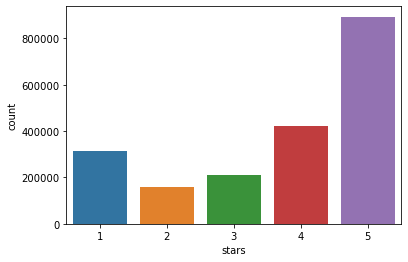

In [7]:
sns.countplot(simplified_reviews_pd['stars'])

In [8]:
counter_star = Counter(simplified_reviews_pd['stars'])

In [9]:
min_class = -1
min_amount = 1000000000
for cs in counter_star:
    if min_amount > counter_star[cs]:
        min_amount = counter_star[cs]
        min_class = cs
min_class, min_amount

(2, 158557)

In [10]:
remove_amounts = {c: abs(min_amount - counter_star[c]) for c in counter_star}
remove_amounts

{1: 153990, 5: 735443, 4: 264500, 3: 53281, 2: 0}

In [11]:
remove_amounts[1] -= 1
remove_amounts

{1: 153989, 5: 735443, 4: 264500, 3: 53281, 2: 0}

In [12]:
%%time
drop_indices = []
for index, row in simplified_reviews_pd.iterrows():
    if remove_amounts[row['stars']] > 0:
        remove_amounts[row['stars']] -= 1
        drop_indices.append(index)
len(drop_indices)

CPU times: user 3min 38s, sys: 43 ms, total: 3min 38s
Wall time: 3min 38s


1207213

In [13]:
balanced_simplified_reviews = simplified_reviews_pd.drop(drop_indices)

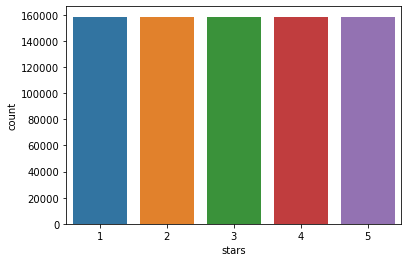

In [14]:
sns.countplot(balanced_simplified_reviews['stars'])

In [15]:
balanced_simplified_reviews['stars'].unique()

array([2, 3, 1, 4, 5])

In [16]:
balanced_simplified_reviews['stars'].value_counts()

1    158558
5    158557
4    158557
3    158557
2    158557
Name: stars, dtype: int64

In [17]:
balanced_simplified_reviews.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 792786 entries, 31 to 1999998
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   text    792786 non-null  object
 1   stars   792786 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 38.1+ MB


In [18]:
balanced_simplified_reviews

,text,stars
31,This actually used to be one of my favorite ho...,2
62,Decent food. Fishermen lobster or even congee ...,2
77,"Pros: Fun atmosphere, great for people watchin...",2
85,"I love bookstores, and I love to spend some ti...",2
86,"I passed Five Guys, In-N-Out, Carl's Jr, and S...",2
...,...,...
1999994,This place is excellent. I never knew about th...,5
1999995,An all-time favorite for me and my wife. We g...,5
1999996,I have been coming here for over a year now fo...,5
1999997,Worst customer service on the planet! Came in ...,1


In [19]:
from gensim.parsing.preprocessing import STOPWORDS, strip_tags, strip_numeric, strip_punctuation, strip_multiple_whitespaces, remove_stopwords, strip_short, stem_text
from nltk.corpus import stopwords
import re

In [20]:
clean_reviews0 = balanced_simplified_reviews[:200]
for t in clean_reviews0:
    clean_reviews0['text'] = clean_reviews0['text'].apply(lambda t: strip_punctuation(t))
clean_reviews0

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


,text,stars
31,This actually used to be one of my favorite ho...,2
62,Decent food Fishermen lobster or even congee ...,2
77,Pros Fun atmosphere great for people watchin...,2
85,I love bookstores and I love to spend some ti...,2
86,I passed Five Guys In N Out Carl s Jr and S...,2
...,...,...
2438,Cool spot for a night as usual downtown is pr...,2
2451,Had to use up my 2 free nights for September a...,2
2453,Had an opportunity to eat at the breakfast buf...,2
2473,I think I ve been spoiled by eating delicious ...,2


In [21]:
for r in balanced_simplified_reviews:
    balanced_simplified_reviews['text'] = balanced_simplified_reviews['text'].apply(lambda t: strip_numeric(t))
    balanced_simplified_reviews['text'] = balanced_simplified_reviews['text'].apply(lambda t: strip_punctuation(t))
    balanced_simplified_reviews['text'] = balanced_simplified_reviews['text'].apply(lambda t: strip_multiple_whitespaces(t))
    balanced_simplified_reviews['text'] = balanced_simplified_reviews['text'].apply(lambda t: t.lower())
    balanced_simplified_reviews['text'] = balanced_simplified_reviews['text'].apply(lambda t: remove_stopwords(t))
    balanced_simplified_reviews['text'] = balanced_simplified_reviews['text'].apply(lambda t: strip_short(t))

In [22]:
balanced_simplified_reviews

,text,stars
31,actually favorite hotel casinos day things cha...,2
62,decent food fishermen lobster congee queen bet...,2
77,pros fun atmosphere great people watching mech...,2
85,love bookstores love spend time browsing flipp...,2
86,passed guys carl sonic habit won happen know s...,2
...,...,...
1999994,place excellent knew hole wall family came tow...,5
1999995,time favorite wife weekly love martinis love s...,5
1999996,coming year brazilian waxes absolutely love pl...,5
1999997,worst customer service planet came pick cake r...,1


In [23]:
balanced_simplified_reviews.to_pickle('./balanced_cleaned_reviews_full.pkl')

In [24]:
balanced_simplified_reviews['stars'] = balanced_simplified_reviews['stars'] - 1
balanced_simplified_reviews

,text,stars
31,actually favorite hotel casinos day things cha...,1
62,decent food fishermen lobster congee queen bet...,1
77,pros fun atmosphere great people watching mech...,1
85,love bookstores love spend time browsing flipp...,1
86,passed guys carl sonic habit won happen know s...,1
...,...,...
1999994,place excellent knew hole wall family came tow...,4
1999995,time favorite wife weekly love martinis love s...,4
1999996,coming year brazilian waxes absolutely love pl...,4
1999997,worst customer service planet came pick cake r...,0


In [25]:
balanced_simplified_reviews['stars'].unique()

array([1, 2, 0, 3, 4])

In [26]:
NUM_CLASSES = len(balanced_simplified_reviews['stars'].unique())

In [27]:
balanced_simplified_reviews['text'].str.len()

31         1768
62          153
77          241
85          516
86          139
           ... 
1999994     331
1999995      66
1999996     299
1999997     297
1999998     154
Name: text, Length: 792786, dtype: int64

In [28]:
print(balanced_simplified_reviews['text'][86])

passed guys carl sonic habit won happen know stars coming burger tasted like unseasoned sonic burger overpriced guys customer service great


In [29]:
def count_tokens(df):
    df['text_len'] = df['text'].apply(lambda t : len(t))
    return df

In [30]:
b_sim_reviews = balanced_simplified_reviews.copy()
b_sim_reviews = count_tokens(b_sim_reviews)

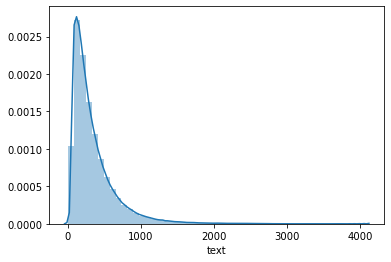

In [31]:

sns.distplot(balanced_simplified_reviews['text'].str.len())